In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

In [2]:
conda install -c conda-forge scikit-plot

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install yfinance
!pip install investpy
!pip install pykrx
!pip install seaborn
!pip install workalendar
!pip install --upgrade finance-datareader
!pip install TA_Lib-0.4.19-cp38-cp38-win_amd64.whl
!pip install -U finance-datareader
!pip install keras

You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


Processing c:\users\user\downloads\ta_lib-0.4.19-cp38-cp38-win_amd64.whl
TA-Lib is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\user\anaconda3\envs\py38_64\python.exe -m pip install --upgrade pip' command.


In [4]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import yfinance as yf # yahoo finance API    # pip install yfinance
import investpy # investing.com API          # pip install investpy
from pykrx import stock # krx API           # pip instasll pykrx
import talib as ta # 기술적 분석 (보조지표)
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
%matplotlib inline

In [5]:
# 크롤링 start_date, end_date
#start_date='2017-01-05'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2018-01-01 : ')
#end_date='2021-01-01'
#input('YYYY-MM-DD 형식을 지켜 입력해주세요 ex) 2020-10-13 : ')
#train_date = '2020-01-01'
start_date = '2010-01-01'
end_date = '2021-02-16'
train_date = '2020-10-01'

In [6]:
# 데이터 수집기간 입력
# yahoo finance 양식, ex) yyyy-mm-dd
#start_date = '2018-01-01'
#end_date = '2020-10-13'

# investing.com 양식, ex) dd/mm/yyyy
start_date_ = start_date[8:] + '/' + start_date[5:7] + '/' + start_date[:4]
end_date_ = end_date[8:] + '/' + end_date[5:7] + '/' + end_date[:4]

# krx 양식 ex) yyyymmdd
start_date__ = start_date[0:4] + start_date[5:7] + start_date[8:10]
end_date__ = end_date[0:4] + end_date[5:7] + end_date[8:10]

In [7]:
# 주요 3개국 대비 원 환율

# 달러/원
exchange_rate_usd_ = investpy.get_currency_cross_historical_data(currency_cross='USD/KRW', from_date=start_date_, to_date=end_date_)
exchange_rate_usd_.columns = ['exchange_rate_usd_Open', 'exchange_rate_usd_High', 'exchange_rate_usd_Low', 'exchange_rate_usd_Close', 'exchange_rate_usd_Currency']
exchange_rate_usd_ = exchange_rate_usd_.drop(['exchange_rate_usd_Open','exchange_rate_usd_High','exchange_rate_usd_Low','exchange_rate_usd_Currency'], axis=1)

# S&P 500
snp_500_ = yf.download("^GSPC", start=start_date, end=end_date)
snp_500_.columns = ['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Close','snp_500_Adj Close','snp_500_Volume']
snp_500_ = snp_500_.drop(['snp_500_Open','snp_500_High','snp_500_Low','snp_500_Adj Close','snp_500_Volume'], axis=1)

# NASDAQ
nasdaq_ = yf.download("^IXIC", start=start_date, end=end_date)
nasdaq_.columns = ['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Close','nasdaq_Adj Close','nasdaq_Volume']
nasdaq_ = nasdaq_.drop(['nasdaq_Open','nasdaq_High','nasdaq_Low','nasdaq_Adj Close','nasdaq_Volume'], axis=1)

# Russell 2000
russell_2000_ = yf.download("^RUT", start=start_date, end=end_date)
russell_2000_.columns = ['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Close','russell_2000_Adj Close','russell_2000_Volume']
russell_2000_ = russell_2000_.drop(['russell_2000_Open','russell_2000_High','russell_2000_Low','russell_2000_Adj Close','russell_2000_Volume'], axis=1)

# 삼성 차트 데이터
sam_ = stock.get_market_ohlcv_by_date(start_date__, end_date__, "005930")
sam_.columns = ['Open','High','Low','Close','Volume']
model_samsung = sam_.copy()

# 3) MACD 이동평균수렴확산 (단기(EMA12)와 장기(EMA26) EMA로 모멘텀을 추정)
macd, macdsignal9, macdhist = ta.MACD(model_samsung.Close, fastperiod=12, slowperiod=26, signalperiod=9)
model_samsung['macd'] = macd
model_samsung['macdsignal9'] = macdsignal9
model_samsung['macdhist'] = macdhist

MSCI_KR = fdr.DataReader('156080', start_date,end_date) #MSCI KOREA
MSCI_KR = MSCI_KR.drop(['Open','High','Low', 'Change','Volume'], axis=1) 
MSCI_KR.columns = ['MSCI_KR']

# HANG SENG
hang_seng_ = yf.download("^HSI", start=start_date, end=end_date)
hang_seng_.columns = ['hang_seng_Open','hang_seng_High','hang_seng_Low','hang_seng_Close','hang_seng_Adj Close','hang_seng_Volume']
hang_seng_ = hang_seng_.drop(['hang_seng_Open','hang_seng_High','hang_seng_Low','hang_seng_Adj Close','hang_seng_Volume'], axis=1)

# 미국 국채 수익률 (5년)
treasury_5y_ = yf.download("^FVX", start=start_date, end=end_date)
treasury_5y_.columns = ['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Close','treasury_5y_Adj Close','treasury_5y_Volume']
treasury_5y_ = treasury_5y_.drop(['treasury_5y_Open','treasury_5y_High','treasury_5y_Low','treasury_5y_Adj Close','treasury_5y_Volume'], axis=1)

# 미국 국채 수익률 (10년)
treasury_10y_ = yf.download("^TNX", start=start_date, end=end_date)
treasury_10y_.columns = ['treasury_10y_Open','treasury_10y_High','treasury_10y_Low','treasury_10y_Close','treasury_10y_Adj Close','treasury_10y_Volume']
treasury_10y_ = treasury_10y_.drop(['treasury_10y_Open','treasury_10y_High','treasury_10y_Low','treasury_10y_Adj Close','treasury_10y_Volume'], axis=1)

# 미국 국채 수익률 (30년)
treasury_30y_ = yf.download("^TYX", start=start_date, end=end_date)
treasury_30y_.columns = ['treasury_30y_Open','treasury_30y_High','treasury_30y_Low','treasury_30y_Close','treasury_30y_Adj Close','treasury_30y_Volume']
treasury_30y_ = treasury_30y_.drop(['treasury_30y_Open','treasury_30y_High','treasury_30y_Low','treasury_30y_Adj Close','treasury_30y_Volume'], axis=1)

# [*에너지*]
# WTI유 시세
crude_oil_ = yf.download("CL=F", start=start_date, end=end_date)
crude_oil_.columns = ['crude_oil_Open','crude_oil_High','crude_oil_Low','crude_oil_Close','crude_oil_Adj Close','crude_oil_Volume']
crude_oil_ = crude_oil_.drop(['crude_oil_Open','crude_oil_High','crude_oil_Low','crude_oil_Adj Close','crude_oil_Volume'], axis=1)

# 브렌트유 시세
brent_crude_oil_ = yf.download("BZ=F", start=start_date, end=end_date)
brent_crude_oil_.columns = ['brent_crude_oil_Open','brent_crude_oil_High','brent_crude_oil_Low','brent_crude_oil_Close','brent_crude_oil_Adj Close','brent_crude_oil_Volume']
brent_crude_oil_ = brent_crude_oil_.drop(['brent_crude_oil_Open','brent_crude_oil_High','brent_crude_oil_Low','brent_crude_oil_Adj Close','brent_crude_oil_Volume'], axis=1)

# SOX 지수 엔비디아(8.9%), 텍사스인스트루먼트(8.6%), 퀄컴(7.7%), 인텔(7.4%) 반도체장비기업 18.52%
SOXX = yf.download("SOXX", start=start_date, end=end_date)
SOXX.columns = ['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Close','SOXX_Adj Close','SOXX_Volume']
SOXX = SOXX.drop(['SOXX_Open','SOXX_High','SOXX_Low','SOXX_Adj Close','SOXX_Volume'], axis=1)

# SMH 인텔(10%), TSMC(10%), 엔비디아(5%)
SMH = yf.download("SMH", start=start_date, end=end_date)
SMH.columns = ['SMH_Open','SMH_High','SMH_Low','SMH_Close','SMH_Adj Close','SMH_Volume']
SMH = SMH.drop(['SMH_Open','SMH_High','SMH_Low','SMH_Close','SMH_Volume'], axis=1)

# SOXL 지수(3배 상승 레버리지) 텍사스인스트루먼트(8.6%) 인텔(8.3%), 퀄컴(7.8%), 엔비디아(7.8%)
SOXL = yf.download("SOXL", start=start_date, end=end_date)
SOXL.columns = ['SOXL_Open','SOXL_High','SOXL_Low','SOXL_Close','SOXL_Adj Close','SOXL_Volume']
SOXL = SOXL.drop(['SOXL_Open','SOXL_High','SOXL_Low','SOXL_Close','SOXL_Volume'], axis=1)

# SOXS 지수(3배 인버스 레버리지) 텍사스인스트루먼트(8.6%) 인텔(8.3%), 퀄컴(7.8%), 엔비디아(7.8%)
SOXS = yf.download("SOXS", start=start_date, end=end_date)
SOXS.columns = ['SOXS_Open','SOXS_High','SOXS_Low','SOXS_Close','SOXS_Adj Close','SOXS_Volume']
SOXS = SOXS.drop(['SOXS_Open','SOXS_High','SOXS_Low','SOXS_Close','SOXS_Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
model_samsung['US'] = exchange_rate_usd_
model_samsung['SNP500'] = snp_500_
model_samsung['RUSSELL2000'] = russell_2000_
model_samsung['NASDAQ'] = nasdaq_
model_samsung['MSCI_KR'] = MSCI_KR
model_samsung['SOXX'] = SOXX
model_samsung['SMH'] = SMH
model_samsung['SOXL'] = SOXL
model_samsung['SOXS'] = SOXS
model_samsung['TREASURY_5Y']=treasury_5y_
model_samsung['TREASURY_10Y']=treasury_10y_
model_samsung['TREASURY_30Y']=treasury_30y_
#model_samsung['crude_oil'] = crude_oil_
#model_samsung['brent_crude_oil'] = brent_crude_oil_
model_samsung['hang_seng'] = hang_seng_


In [9]:
lst_label = ['a']

for i in range(len(model_samsung)-1):
    if model_samsung.iloc[i+1]['Close'] == model_samsung.iloc[i]['Close']:
        lst_label.append(2) # 전일 주가 = 당일 주가 : 2
    elif model_samsung.iloc[i+1]['Close'] > model_samsung.iloc[i]['Close']:
        lst_label.append(0) # 전일 주가 < 당일 주가 : 0
    else:
        lst_label.append(1) # 전일 주가 > 당일 주가 : 1
model_samsung['Labeling'] = lst_label
model_samsung = model_samsung.drop(model_samsung[model_samsung['Labeling'] == 'a'].index) # 첫 행 삭제
model_samsung = model_samsung.drop(model_samsung[model_samsung['Labeling'] == 2].index) # 전일 주가 = 당일 주가인 행 삭제
model_samsung['Labeling'] = model_samsung['Labeling'].astype("category")

In [10]:
# samsung 모델
#model_samsung['Labeling'] = model_samsung['Close'].shift(-1)
model_samsung = model_samsung.dropna() # 결측치가 있는 행 제거
model_samsung

,Open,High,Low,Close,Volume,macd,macdsignal9,macdhist,US,SNP500,...,MSCI_KR,SOXX,SMH,SOXL,SOXS,TREASURY_5Y,TREASURY_10Y,TREASURY_30Y,hang_seng,Labeling
날짜,,,,,,,,,,,,,,,,,,,,,
2012-04-30,27900,28180,27540,27800,315924,514.972445,386.143049,128.829397,1130.15,1397.910034,...,10609.0,56.110001,30.272848,8.517699,326388.56250,0.811,1.915,3.109,21094.210938,0
2012-05-02,28200,28360,27980,28200,368585,619.193325,432.753104,186.440222,1130.20,1402.310059,...,10718.0,56.549999,30.570417,8.738206,318693.37500,0.819,1.922,3.114,21309.080078,0
2012-05-03,28040,28200,27960,28020,206721,679.432553,482.088994,197.343559,1131.25,1391.569946,...,10655.0,55.139999,29.879015,8.111872,341591.28125,0.817,1.924,3.112,21249.529297,1
2012-05-04,27499,27960,26980,27200,410013,653.472602,516.365715,137.106887,1135.85,1369.099976,...,10578.0,54.029999,29.196362,7.588751,363269.15625,0.784,1.880,3.071,21086.000000,1
2012-05-07,26840,27060,26500,26840,378463,596.968679,532.486308,64.482371,1138.50,1369.579956,...,10377.0,53.869999,29.143854,7.541834,364582.96875,0.782,1.877,3.067,20536.650391,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04,83500,83800,82100,82500,24171688,1106.482095,2186.019635,-1079.537540,1120.00,3871.739990,...,20290.0,408.399994,236.929993,563.070007,13.46000,0.459,1.139,1.933,29113.500000,1
2021-02-05,83100,84000,82500,83500,18036835,936.864812,1936.188670,-999.323858,1116.77,3886.830078,...,20535.0,405.609985,235.210007,550.840027,13.77000,0.467,1.170,1.974,29288.679688,0
2021-02-08,83800,84200,83000,83000,15338765,753.411216,1699.633179,-946.221963,1115.61,3915.590088,...,20355.0,417.779999,243.070007,602.000000,12.49000,0.475,1.160,1.943,29319.470703,1


In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [12]:
model_samsung['range'] = model_samsung['High'] - model_samsung['Low'] 

In [13]:
model_samsung

,Open,High,Low,Close,Volume,macd,macdsignal9,macdhist,US,SNP500,...,SOXX,SMH,SOXL,SOXS,TREASURY_5Y,TREASURY_10Y,TREASURY_30Y,hang_seng,Labeling,range
날짜,,,,,,,,,,,,,,,,,,,,,
2012-04-30,27900,28180,27540,27800,315924,514.972445,386.143049,128.829397,1130.15,1397.910034,...,56.110001,30.272848,8.517699,326388.56250,0.811,1.915,3.109,21094.210938,0,640
2012-05-02,28200,28360,27980,28200,368585,619.193325,432.753104,186.440222,1130.20,1402.310059,...,56.549999,30.570417,8.738206,318693.37500,0.819,1.922,3.114,21309.080078,0,380
2012-05-03,28040,28200,27960,28020,206721,679.432553,482.088994,197.343559,1131.25,1391.569946,...,55.139999,29.879015,8.111872,341591.28125,0.817,1.924,3.112,21249.529297,1,240
2012-05-04,27499,27960,26980,27200,410013,653.472602,516.365715,137.106887,1135.85,1369.099976,...,54.029999,29.196362,7.588751,363269.15625,0.784,1.880,3.071,21086.000000,1,980
2012-05-07,26840,27060,26500,26840,378463,596.968679,532.486308,64.482371,1138.50,1369.579956,...,53.869999,29.143854,7.541834,364582.96875,0.782,1.877,3.067,20536.650391,1,560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-04,83500,83800,82100,82500,24171688,1106.482095,2186.019635,-1079.537540,1120.00,3871.739990,...,408.399994,236.929993,563.070007,13.46000,0.459,1.139,1.933,29113.500000,1,1700
2021-02-05,83100,84000,82500,83500,18036835,936.864812,1936.188670,-999.323858,1116.77,3886.830078,...,405.609985,235.210007,550.840027,13.77000,0.467,1.170,1.974,29288.679688,0,1500
2021-02-08,83800,84200,83000,83000,15338765,753.411216,1699.633179,-946.221963,1115.61,3915.590088,...,417.779999,243.070007,602.000000,12.49000,0.475,1.160,1.943,29319.470703,1,1200


In [14]:

#4 test, train 나누기
#df_scaled = model_samsung.copy()
#df_scaled.drop(['hang_seng','Labeling','Open','High','Low','Volume','macdsignal9', 'macdhist', 'RUSSELL2000', 'NASDAQ', 'MSCI_KR', 'SMH','TREASURY_10Y','TREASURY_30Y'],axis=1,inplace=True)
#model_samsung.drop(['SOXS','SOXX','Open','High','Low','Volume','macd','macdsignal9','macdhist', 'RUSSELL2000', 'NASDAQ', 'MSCI_KR', 'SMH','TREASURY_10Y'],axis=1,inplace=True)

model_samsung.drop(['MSCI_KR','SOXL', 'NASDAQ','SNP500','SMH','SOXX','Open','High','Low','macdhist','SOXS','TREASURY_10Y','TREASURY_30Y'],axis=1,inplace=True)


In [15]:
# 차트 비교분석을 위한 정규화
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(model_samsung)
output = min_max_scaler.transform(model_samsung)
output = pd.DataFrame(output, columns=model_samsung.columns, index=list(model_samsung.index.values))
print(output.head())

               Close    Volume      macd  macdsignal9        US  RUSSELL2000  \
2012-04-30  0.092736  0.002483  0.468804     0.435490  0.457669     0.050994   
2012-05-02  0.098478  0.003066  0.480425     0.441659  0.457859     0.052095   
2012-05-03  0.095894  0.001272  0.487142     0.448188  0.461845     0.044405   
2012-05-04  0.084123  0.003526  0.484247     0.452725  0.479309     0.034961   
2012-05-07  0.078955  0.003176  0.477947     0.454858  0.489370     0.036222   

            TREASURY_5Y  hang_seng  Labeling     range  
2012-04-30     0.212781   0.194316       0.0  0.075000  
2012-05-02     0.215544   0.208670       0.0  0.038889  
2012-05-03     0.214853   0.204692       1.0  0.019444  
2012-05-04     0.203454   0.193767       1.0  0.122222  
2012-05-07     0.202763   0.157067       1.0  0.063889  


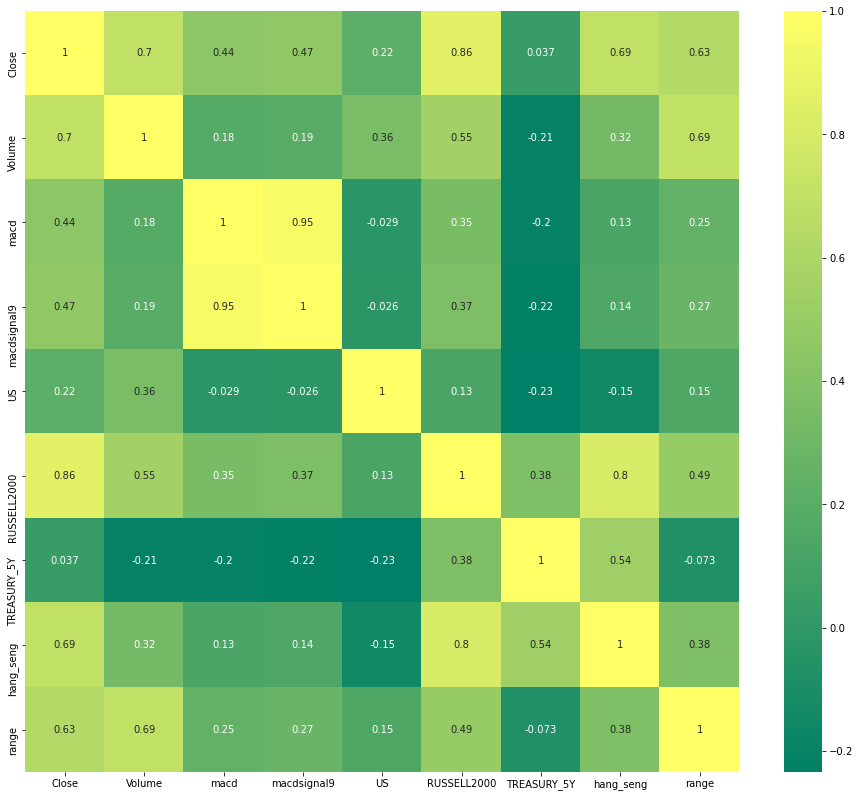

In [16]:
import seaborn as sns
plt.figure(figsize=(16,14))
sns.heatmap(model_samsung.corr(), annot=True, cmap='summer')

In [17]:
Y = output['Labeling']
X = output.drop(['Labeling','Close'], axis=1).shift(-5).fillna(output.mean())

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [19]:
neighbor_model = KNeighborsClassifier(n_neighbors=5)
svm_model = SVC()
forest_model = RandomForestClassifier(n_estimators=300)
gbm_model = GradientBoostingClassifier(random_state=10)
xgb_model = XGBClassifier(n_estimators=300)
lgb_model = LGBMClassifier(n_estimators=300)

model_list = [neighbor_model, svm_model, forest_model, gbm_model, xgb_model, lgb_model]

for model in model_list:
    model_name = model.__class__.__name__
    model.fit(X_train , y_train)
    print('\n{0} 학습데이터셋 정확도: {1:.4f}'.format(model_name, model.score(X_train , y_train)))
 
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)    
    print('{0} 테스트셋 정확도: {1:.4f}'.format(model_name, accuracy))    


KNeighborsClassifier 학습데이터셋 정확도: 0.7041
KNeighborsClassifier 테스트셋 정확도: 0.4741

SVC 학습데이터셋 정확도: 0.5658
SVC 테스트셋 정확도: 0.5586

RandomForestClassifier 학습데이터셋 정확도: 0.9993
RandomForestClassifier 테스트셋 정확도: 0.5276

GradientBoostingClassifier 학습데이터셋 정확도: 0.7811
GradientBoostingClassifier 테스트셋 정확도: 0.5138
[16:57:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\envs\py38_64\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



XGBClassifier 학습데이터셋 정확도: 0.9993
XGBClassifier 테스트셋 정확도: 0.5431

LGBMClassifier 학습데이터셋 정확도: 0.9993
LGBMClassifier 테스트셋 정확도: 0.5103


In [20]:
X_train.shape

(1352, 8)

In [21]:
# 모델의 설정
model = Sequential()
model.add(Dense(60, input_dim=8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# 모델 실행
model.fit(X_train, y_train, epochs=300, batch_size=18)

Epoch 1/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6956 - accuracy: 0.5022
Epoch 2/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6912 - accuracy: 0.5311
Epoch 3/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6907 - accuracy: 0.5355
Epoch 4/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.5355
Epoch 5/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6896 - accuracy: 0.5385
Epoch 6/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6891 - accuracy: 0.5510
Epoch 7/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6892 - accuracy: 0.5340
Epoch 8/300
76/76 [==============================] - 0s 999us/step - loss: 0.6885 - accuracy: 0.5333
Epoch 9/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6893 - accuracy: 0.5407
Epoch 10/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.5362
Epoch 1

76/76 [==============================] - 0s 986us/step - loss: 0.6730 - accuracy: 0.5784
Epoch 162/300
76/76 [==============================] - 0s 986us/step - loss: 0.6728 - accuracy: 0.5784
Epoch 163/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6731 - accuracy: 0.5888
Epoch 164/300
76/76 [==============================] - 0s 2ms/step - loss: 0.6745 - accuracy: 0.5710
Epoch 165/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6733 - accuracy: 0.5769
Epoch 166/300
76/76 [==============================] - 0s 986us/step - loss: 0.6739 - accuracy: 0.5710
Epoch 167/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6725 - accuracy: 0.5799
Epoch 168/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6729 - accuracy: 0.5777
Epoch 169/300
76/76 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.5703
Epoch 170/300
76/76 [==============================] - 0s 1ms/step - loss: 0.6730 - accuracy: 0.576

In [22]:
eval = model.evaluate(X_test, (y_test))
print('{0} 정확도: {1:.4f}, Loss: {2:.4f}'.format(model.__class__.__name__, eval[1], eval[0]))

19/19 [==============================] - 0s 947us/step - loss: 0.6850 - accuracy: 0.5621
Sequential 정확도: 0.5621, Loss: 0.6850


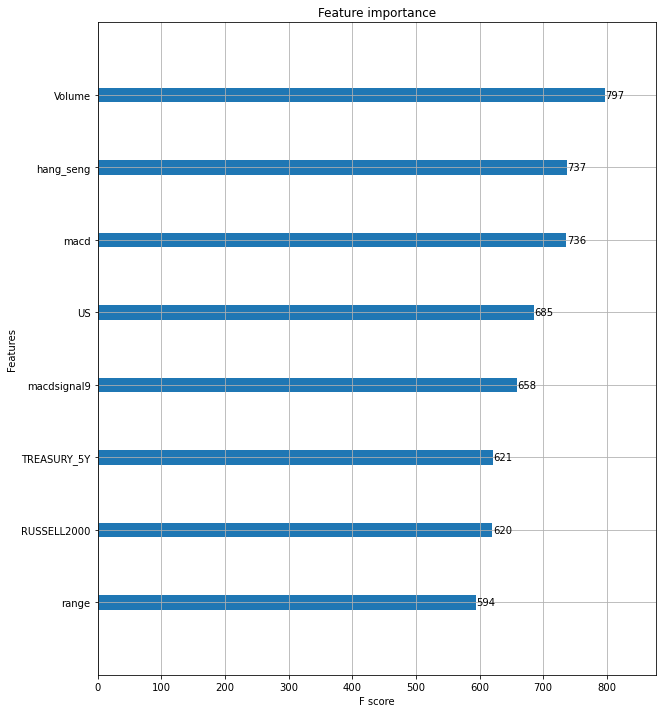

In [23]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

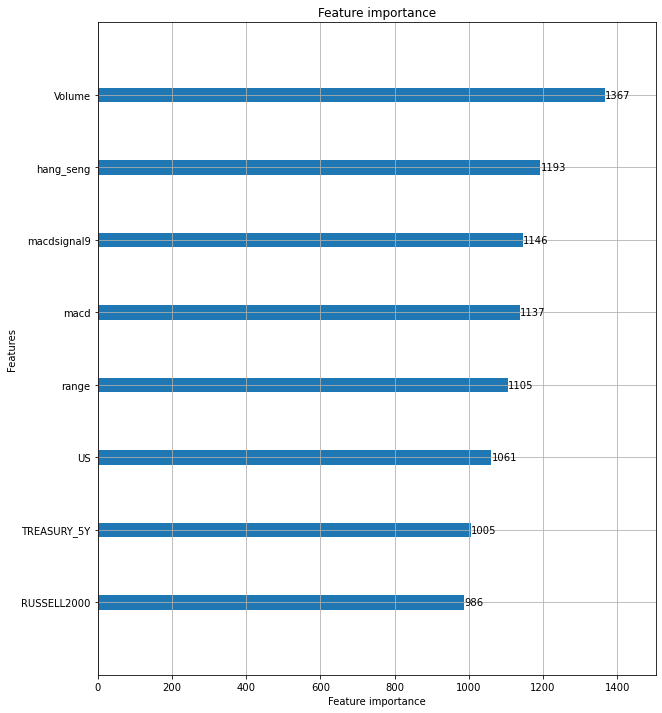

In [24]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgb_model, ax=ax)

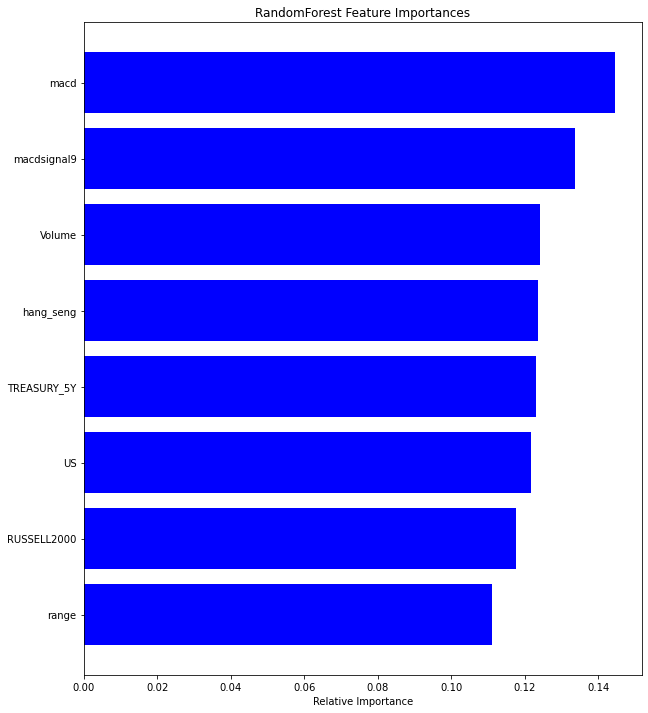

In [25]:
features = X.columns
importances = forest_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 12))
plt.title('RandomForest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

(2) GridSearch
'n_estimators':[300],
'max_depth' : [6, 8, 10, 12],
'min_samples_leaf' : [8, 12, 18 ],
'min_samples_split' : [8, 16, 20]

모델의 최적 파라메터를 도출하기 위해서 Grid Search를 이용한다. Scikit-learn의 GridSearchCV 클래스를 이용하면 쉽게 진행할 수 있다. 해당 모델의 주요 파라메터는 아래와 같다.

참고문서: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


In [26]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[300],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 300}
최고 예측 정확도: 0.5518


In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer # 평가지표
param_list = {"n_estimators": list(range(300, 500, 10)),
              "max_depth": [6, 12, 16, 20],
              "min_samples_split": [2, 4, 6, 8]}

rf_model = RandomForestClassifier()

rf_random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions = param_list,
        n_iter = 10,
        cv = 2,
        scoring = make_scorer(accuracy_score))

rf_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [6, 12, 16, 20],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [300, 310, 320, 330,
                                                         340, 350, 360, 370,
                                                         380, 390, 400, 410,
                                                         420, 430, 440, 450,
                                                         460, 470, 480, 490]},
                   scoring=make_scorer(accuracy_score))

In [28]:
rf_random_search.best_params_

{'n_estimators': 440, 'min_samples_split': 2, 'max_depth': 6}

In [29]:
test_scores = []
train_preds = rf_random_search.predict(X_train)
test_preds  = rf_random_search.predict(X_test)

test_scores.append(round(accuracy_score(y_test, test_preds), 1))

print(' 훈련 정확도: {0:.2}'.format(round(accuracy_score(y_train, train_preds), 1)), "\n",
      '시험 정확도: {0:.2}'.format(round(accuracy_score(y_test,  test_preds), 1)), )

 훈련 정확도: 0.8 
 시험 정확도: 0.6


Ensemble
각 분류기의 예측률을 평균 내어 확률이 가장  높은 클래스로 예측(가중치 투표)
Voting Classifier에는 
1. Random forest Classifier
2. Gradient Boosting Classifier
3. XGBoost Classifier
4. SVC(Support Vector Machine)

In [30]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[('forest',forest_model),\
                                            ('xgb',xgb_model)] , voting='soft' )

voting_model.fit(X_train , y_train)
pred = voting_model.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('VotingClassifier 정확도: {0:.4f}'.format(accuracy))

C:\Users\user\anaconda3\envs\py38_64\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
VotingClassifier 정확도: 0.5293
